In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Grid based SEPP method(s)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import sepp.grid_nonparam

# With real data

In [3]:
import open_cp.sources.chicago
import open_cp.geometry
import opencrimedata.chicago
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")

In [4]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_redist_network_flow_to_buildings_network.csv.xz"), "rt") as file:
    all_points = opencrimedata.chicago.load_to_open_cp(file, "BURGLARY")

In [5]:
northside = open_cp.sources.chicago.get_side("South")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [6]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

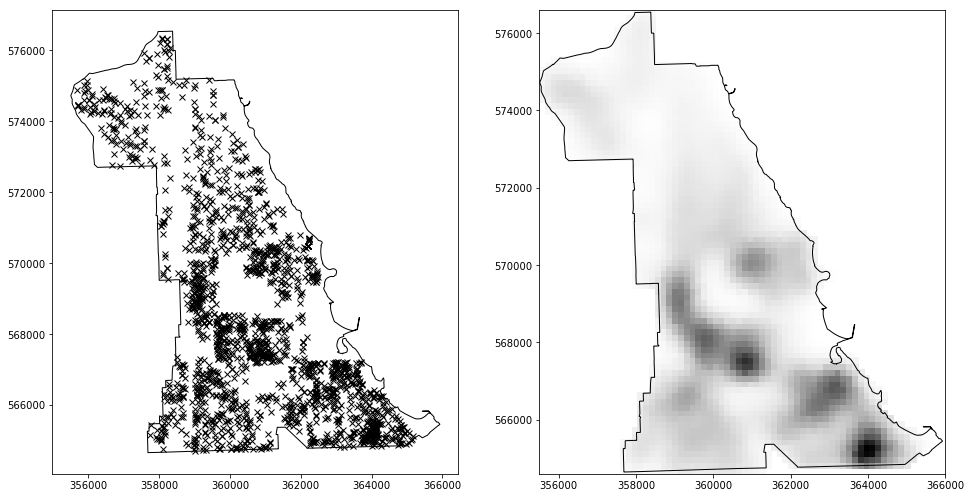

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

## Train

In [8]:
trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=1.5)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=True)

In [9]:
model

ExpDecayModel(T=364.4583333333333, theta=0.009133541033170918, bandwidth=1.5, alpha=[  9.99911790e-01   4.45003346e-06   1.54234344e-09   2.35524742e-09   2.00605784e-10   8.37556636e-05   7.25905504e-16   4.77558503e-12   3.26691968e-13   6.16595004e-20 ... ]

In [10]:
pred = trainer.prediction_from_background(model)

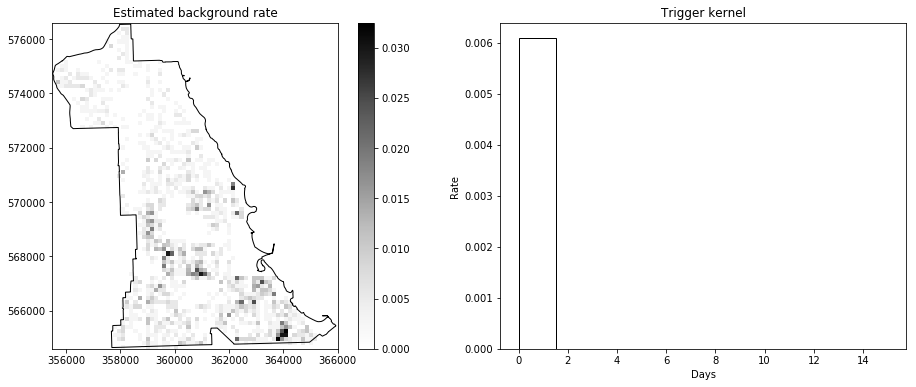

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("Estimated background rate")

ax = axes[1]
x = np.arange(10) * (trainer.time_unit / np.timedelta64(1,"D")) * model.bandwidth
#ax.scatter(x, model.alpha[:len(x)] * model.theta)
ax.set(xlabel="Days", ylabel="Rate", title="Trigger kernel")
ax.bar(x + (x[1] - x[0]) / 2, model.alpha[:len(x)] * model.theta / model.bandwidth,
    model.bandwidth, color="None", edgecolor="black")
#ax.bar(x + (x[1] - x[0]) / 2, model.trigger(None, x), model.bandwidth, color="None", edgecolor="black")
None

In [12]:
np.max(model.mu), np.min(model.mu)

(0.032492521027017371, 0.0)

## Varying bandwidth

In [13]:
bandwidths = [0.05, 0.15, 0.3, 1]
models = {}
for b in bandwidths:
    trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=b)
    trainer.data = points
    models[b] = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=True)
    print(b, models[b])

0.05 ExpDecayModel(T=364.4583333333333, theta=0.07873539854977664, bandwidth=0.05, alpha=[  4.31120172e-02   3.38748237e-02   2.08544809e-02   1.52589773e-02   0.00000000e+00   4.08173992e-03   0.00000000e+00   6.72648652e-20   2.28103929e-02   1.69673062e-03 ... ]
0.15 ExpDecayModel(T=364.4583333333333, theta=0.024906746474964513, bandwidth=0.15, alpha=[  3.09920880e-01   4.47847677e-02   6.11836315e-02   6.41251269e-06   8.29525121e-03   2.35757911e-06   1.08380762e-23   3.17536983e-04   3.03788704e-10   1.85450283e-27 ... ]
0.3 ExpDecayModel(T=364.4583333333333, theta=0.013363394535504296, bandwidth=0.3, alpha=[  6.40864801e-01   1.21797219e-01   3.10479367e-03   4.08574483e-11   1.64393694e-16   7.55853928e-09   2.18851011e-11   1.72859629e-03   2.59890193e-04   1.37980978e-09 ... ]
1 ExpDecayModel(T=364.4583333333333, theta=0.012026928933605237, bandwidth=1, alpha=[  8.77522897e-01   8.09180694e-09   6.29789404e-07   9.44040864e-09   1.00335664e-09   1.31569024e-10   1.31173570e-0

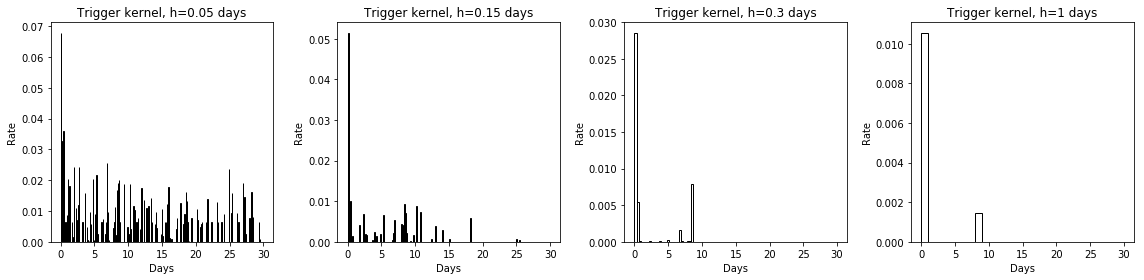

In [14]:
fig, axes = plt.subplots(ncols=4, figsize=(16,4))

for ax, (b, model), s in zip(axes, models.items(), [600,200,100,30]):
    x = np.arange(s) * (trainer.time_unit / np.timedelta64(1,"D")) * model.bandwidth
    ax.set(xlabel="Days", ylabel="Rate", title="Trigger kernel, h={} days".format(b))
    ax.bar(x + (x[1] - x[0]) / 2, model.alpha[:len(x)] * model.theta / model.bandwidth,
           model.bandwidth, color="None", edgecolor="black")
fig.tight_layout()
#fig.savefig("../south_trigger.pdf")

In [15]:
bandwidths = [0.05, 0.15, 0.3, 1]
models = {}
for b in bandwidths:
    trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=b)
    trainer.data = points
    models[b] = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=True)
    print(b, models[b])

0.05 ExpDecayModel(T=364.4583333333333, theta=0.07873539854977664, bandwidth=0.05, alpha=[  4.31120172e-02   3.38748237e-02   2.08544809e-02   1.52589773e-02   0.00000000e+00   4.08173992e-03   0.00000000e+00   6.72648652e-20   2.28103929e-02   1.69673062e-03 ... ]
0.15 ExpDecayModel(T=364.4583333333333, theta=0.024906746474964513, bandwidth=0.15, alpha=[  3.09920880e-01   4.47847677e-02   6.11836315e-02   6.41251269e-06   8.29525121e-03   2.35757911e-06   1.08380762e-23   3.17536983e-04   3.03788704e-10   1.85450283e-27 ... ]
0.3 ExpDecayModel(T=364.4583333333333, theta=0.013363394535504296, bandwidth=0.3, alpha=[  6.40864801e-01   1.21797219e-01   3.10479367e-03   4.08574483e-11   1.64393694e-16   7.55853928e-09   2.18851011e-11   1.72859629e-03   2.59890193e-04   1.37980978e-09 ... ]
1 ExpDecayModel(T=364.4583333333333, theta=0.012026928933605237, bandwidth=1, alpha=[  8.77522897e-01   8.09180694e-09   6.29789404e-07   9.44040864e-09   1.00335664e-09   1.31569024e-10   1.31173570e-0

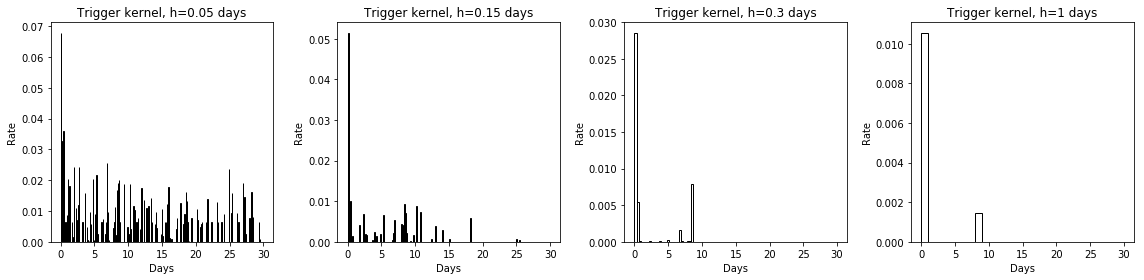

In [16]:
fig, axes = plt.subplots(ncols=4, figsize=(16,4))

for ax, (b, model), s in zip(axes, models.items(), [600,200,100,30]):
    x = np.arange(s) * (trainer.time_unit / np.timedelta64(1,"D")) * model.bandwidth
    ax.set(xlabel="Days", ylabel="Rate", title="Trigger kernel, h={} days".format(b))
    ax.bar(x + (x[1] - x[0]) / 2, model.alpha[:len(x)] * model.theta / model.bandwidth,
           model.bandwidth, color="None", edgecolor="black")
fig.tight_layout()

# Other regions of chicago

In [17]:
sides = ["Far North", "Northwest", "North", "West", "Central",
    "South", "Southwest", "Far Southwest", "Far Southeast"]

In [18]:
def load(side):
    geo = open_cp.sources.chicago.get_side(side)
    grid = open_cp.data.Grid(150, 150, 0, 0)
    grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)
    mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
    points = all_points[mask]
    points = open_cp.geometry.intersect_timed_points(points, geo)
    return grid, points

In [19]:
bandwidths = [0.05, 0.15, 0.3, 1]

models = {}
for side in sides:
    grid, points = load(side)
    models[side] = {}
    for b in bandwidths:
        trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=b)
        trainer.data = points
        #try:
        #    models[side][b] = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=False)
        #except ValueError as ex:
            #print("Failed because {} for {}/{}".format(ex, side, b))
        #    print("Failed: {}/{}".format(side, b))
        models[side][b] = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=True)

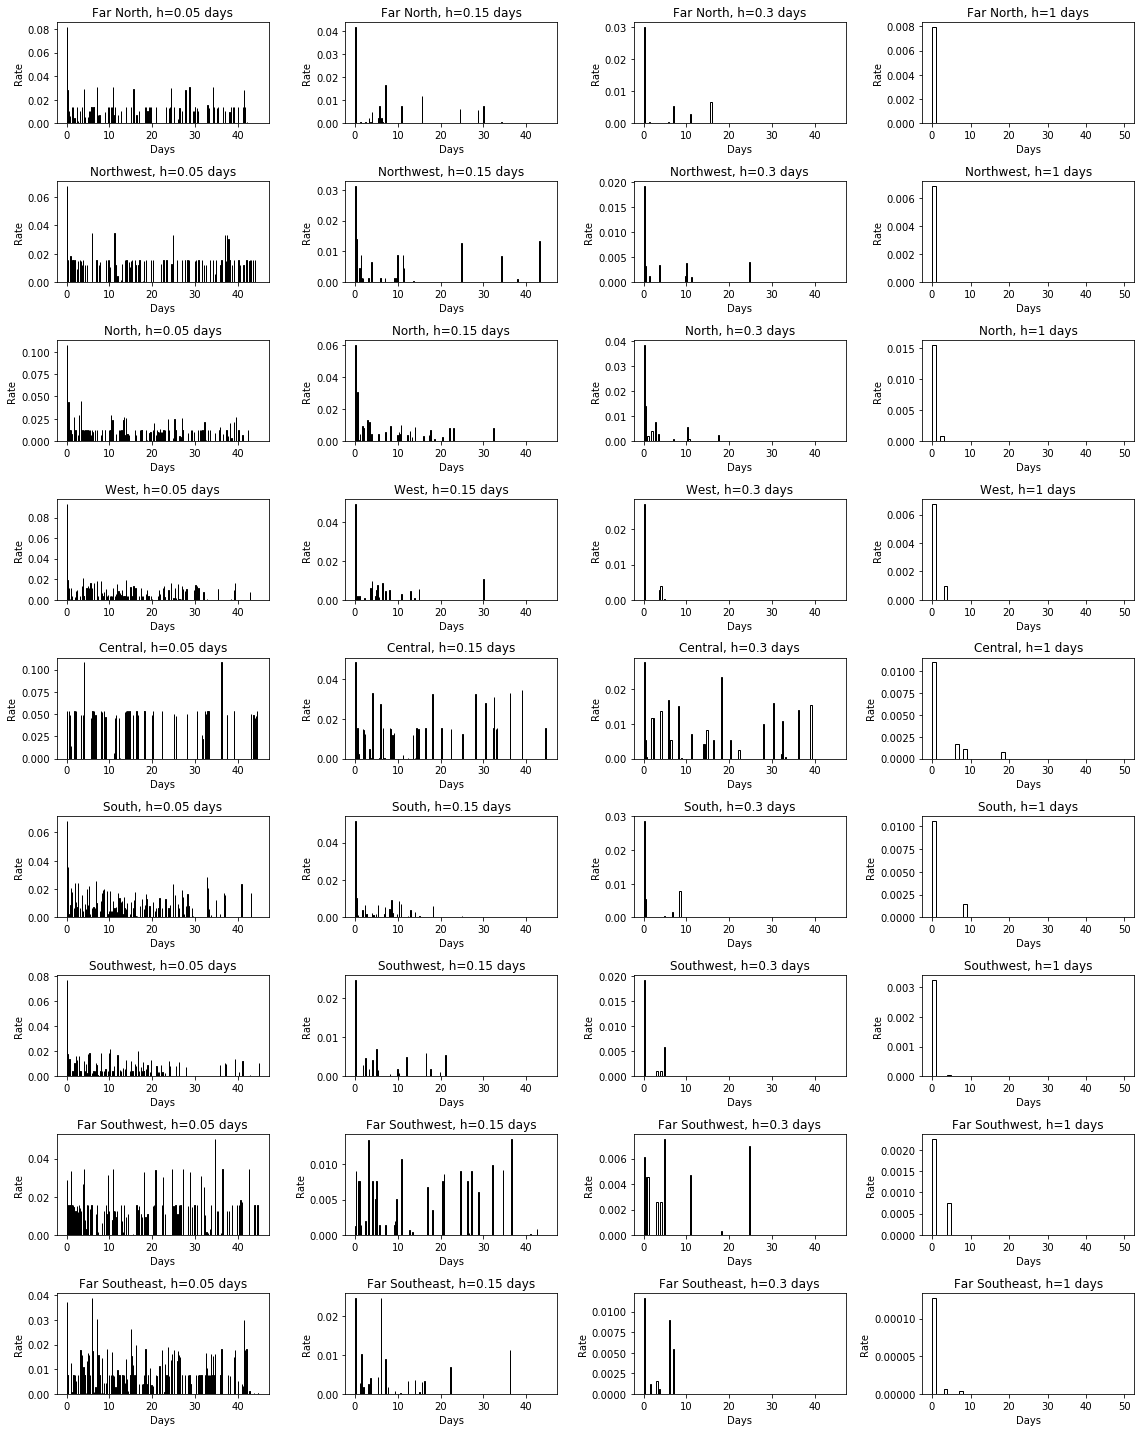

In [20]:
fig, axes = plt.subplots(ncols=4, nrows=len(sides), figsize=(16,20))

for side, axe in zip(sides, axes):
    for ax, bw, s in zip(axe, models[side], [900,300,150,50]):
        model = models[side][bw]
        x = np.arange(s) * (trainer.time_unit / np.timedelta64(1,"D")) * model.bandwidth
        ax.set(xlabel="Days", ylabel="Rate", title="{}, h={} days".format(side, bw))
        ax.bar(x + (x[1] - x[0]) / 2, model.alpha[:len(x)] * model.theta / model.bandwidth,
               model.bandwidth, color="None", edgecolor="black")

fig.tight_layout()